# Simulation of a crack growth in a thick square plate based on Peridynamic Theory

Silling, S. A., & Askari, E. (2005). *A meshfree method based on the peridynamic model of solid mechanics*. *Computers & Structures, 83*(17-18), 1526-1535. https://doi.org/10.1016/j.compstruc.2004.11.026

## Setup

### Setup Python Modules

In this section, we will import the python libraries:

- **NumPy**: This library is fundamental for numerical computations in Python. It provides support for arrays, matrices, and many mathematical functions that operate on these data structures.
- **Matplotlib**: A plotting library for creating static, animated, and interactive visualizations in Python. It's particularly useful for generating plots, histograms, and other types of charts.

In [8]:
import numpy as np  # Importing the NumPy library for numerical operations and handling arrays
import matplotlib.pyplot as plt  # Importing the Pyplot module from Matplotlib for plotting and visualizations
import pandas as pd
import seaborn as sns

## Parameters

### Consistency of Units in Calculations

To avoid errors in our calculations, we will adhere to a consistent set of units for the following physical quanities:

- Length/Distance: millimeters (mm)
- Mass: kilograms (kg)
- Time: microseconds (μs)

In [9]:
rho = 8e-6 #material density
Young_modulus = 19578.55  # Everything in kg and mm
nu = 0.3 #Poisson's Ratio
K = Young_modulus/(3.0*(1-2.0*nu))
horizon = 1.6
s0 = 0.02
total_time = 15
del_T = .5
time_steps = int(total_time/del_T)

<img src="fig5.png" alt="Velocity applied to plate horizontal edges" width="600">

In [10]:
"""
    velocity is given as boundary condition, therefore, convert it to displacement first.
"""
u_applied_05 = np.linspace(2e-2,2e-2,time_steps//3)
u_applied_510 = np.linspace(-2e-2,-2e-2,time_steps//3)
u_applied_1015 = np.linspace(0,0,time_steps//3)
u_applied = np.concatenate((u_applied_05, u_applied_510, u_applied_1015))
print(u_applied)
#where u is displacement at the boundaries

[ 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02 -0.02 -0.02
 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02  0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.  ]


## Generating Meshfree Geometry

In [26]:
"""
    -------------------------
    | 1 | 2 | 3 | 4 | 5 | 6 |
    -------------------------  
"""

# I do not need y in this example.
# INdex should only be 1

ntotal = 6

x_min = 2
x_max = 12

x_coord = np.linspace(x_min, x_max, ntotal)

nnodes = ntotal

coord_array = np.zeros((nnodes, 1))

vol = (x_coord[1] - x_coord[0]) * 1.0

top_nodes = []
bottom_nodes = []
count = 0

for i in range(ntotal):
    coord_array[]

In [27]:
vol

2.0

In [59]:
def Create_geometry():
    # Define the number of divisions along the x and y axes
    nx = 4 # Number of divisions in the x-direction
    ny = 4 # Number of divisions in the y-direction

     # Define the minimum and maximum coordinates for x and y axes
    x_min = 2     # Minimum x-coordinate (in mm)
    x_max = 24    # Maximum x-coordinate (in mm)
    y_min = 2     # Minimum y-coordinate (in mm)
    y_max = 24    # Maximum y-coordinate (in mm)

    # Generate linearly spaced coordinates for x and y axes
    x_coord = np.linspace(x_min,x_max, nx)  # x-coordinates
    y_coord = np.linspace(y_min, y_max, ny) # y-coordinates

    # Calculate the total number of nodes
    nnodes = nx*ny # Total number of nodes in the grid

    # Initialize an array to hold the coordinates of all nodes
    coord_array = np.zeros((nnodes,2)) # Array to store x and y coordinates of each node

    # Calculate the volume of the node, assuming a thickness of 1 mm
    vol = (x_coord[1] - x_coord[0]) * (y_coord[1] - y_coord[0]) * 1.0 

     # Initialize lists to store the indices of top and bottom nodes
    top_nodes = []
    bottom_nodes = []
    count = 0

    # Loop through all the nodes and identify boundary nodes
    for i in range(nx):
        for k in range(ny):
            coord_array[count,0] = x_coord[k] # Fetch x-coordinate of current node
            coord_array[count, 1] = y_coord[i] # Fetch y-coordinate of current node
            
            # Identify and store nodes on the top boundary (y = y_max)
            if y_coord[i] == y_max:
                top_nodes.append(count)

            # Identify and store nodes on the bottom boundary (y = y_min)
            if y_coord[i] == y_min:
                bottom_nodes.append(count)
            count = count + 1

    # Return the coordinate array, top and bottom node lists, total number of nodes, and node volume
    return coord_array, top_nodes, bottom_nodes, nnodes, vol, nx, ny

In [60]:
coord_array, top_nodes, bottom_nodes, nnodes, vol, nx, ny = Create_geometry()

In [61]:
coord_array.shape

(16, 2)

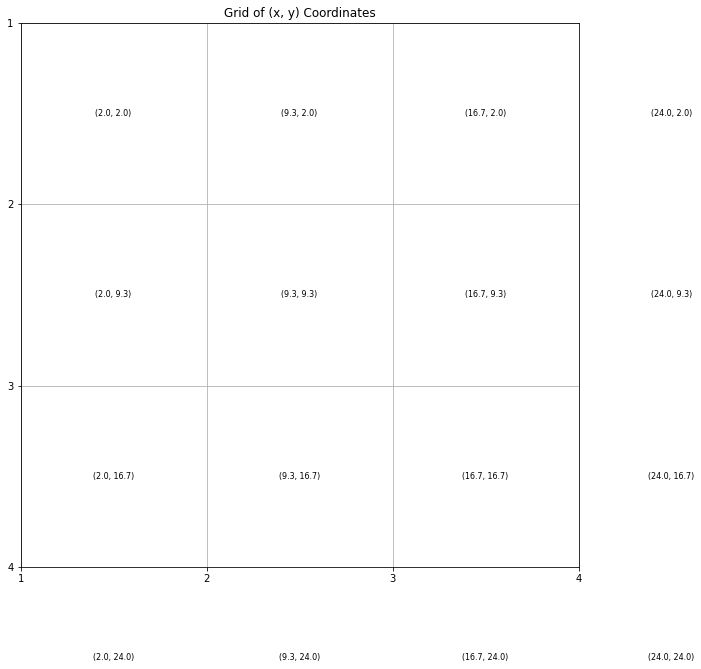

In [64]:
coordinates = coord_array

# Reshape the array into a 6x6 grid
grid_coordinates = coordinates.reshape((nx, ny, 2))

# Set up the plot
plt.figure(figsize=(10, 10))
plt.xticks(ticks=np.arange(nx), labels=np.arange(1, nx+1))
plt.yticks(ticks=np.arange(ny), labels=np.arange(1, ny+1))
plt.grid(True)

# Annotate each cell with the (x, y) coordinates
for i in range(nx):
    for j in range(ny):
        x, y = grid_coordinates[i, j]
        plt.text(j+0.5, i+0.5, f"({x:.1f}, {y:.1f})", ha='center', va='center', fontsize=8)

# Invert the y-axis to match the grid layout
plt.gca().invert_yaxis()

# Add title
plt.title("Grid of (x, y) Coordinates")

# Show the plot
plt.show()

## Neighborsearch

We need to find for each node $x_p$ the neighborhood $H_\delta(x_p)$ such that $H_\delta(x_p)=\lbrace i | \Vert x_i - x_p \Vert \leq \delta \rbrace$.

In [67]:
def Get_nodes_in_horizon(coord_array, nnodes, horizon):

    # Initialize an array to store the indices of nodes within the horizon for each node
    nodal_array = np.zeros((nnodes, 6)).astype(int)
    print(nodal_array.shape)

    # Loop over all nodes to find neighbors within the horizon
    for i in range(nnodes):
        count = 0

        # Loop over all nodes to check their distance from the current node i
        for k in range(nnodes):

            if k!=i: # Skip the comparison with the same node
                x_0 = coord_array[i,0]    # fetch x-coordinate of node i
                y_0 = coord_array[i,1]    # fetch y-coordinate of node i
                x_1 = coord_array[k,0]    # fetch x-coordinate of node k
                y_1 = coord_array[k,1]    # fetch y-coordinate of node k
                R = horizon

                # Calculate the distance between nodes i and k
                dist = (x_1 - x_0)**2.0 + (y_1 - y_0)**2.0

                # Check if node k is within the horizon of node i
                if dist <= R**2.0:
                    nodal_array[i,count] = k  # Store the index of node k in the nodal array for node i
                    count = count + 1 

    return nodal_array

In [68]:
nodal_connectivity = Get_nodes_in_horizon(coord_array, nnodes, horizon)

(16, 6)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


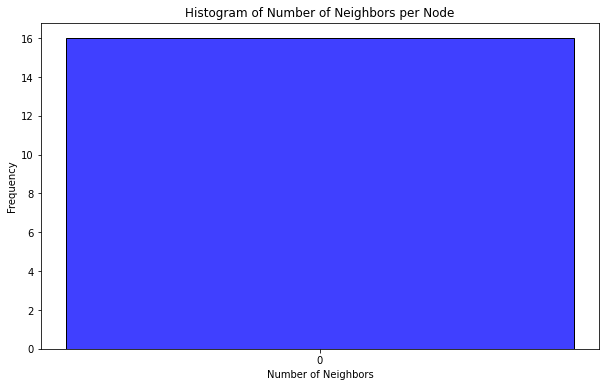

In [69]:
# Count the number of valid neighbors for each node (i.e., non-zero elements)
num_neighbors = np.sum(nodal_connectivity !=0, axis=1)

print(num_neighbors)

# Set up the plot
plt.figure(figsize=(10, 6))

# Create a seaborn histogram (count plot)
sns.histplot(num_neighbors, bins=np.arange(num_neighbors.min(), num_neighbors.max() + 2) - 0.5, kde=False, color='blue')

# Set the x-ticks to be at the center of each bar
plt.xticks(ticks=np.arange(num_neighbors.min(), num_neighbors.max() + 1))

# Add title and labels
plt.title('Histogram of Number of Neighbors per Node')
plt.xlabel('Number of Neighbors')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [8]:
# # Initialize an array to store displacement vectors for each node at every time step
# u_array_store = np.zeros((time_steps,nnodes,2))

# # Initialize an array to store the current displacement vector for each node
# u_array_current = np.zeros_like(coord_array)

# current_time = 0


# for n in range(time_steps):
#     print('Time step:     ', n)
    
#     # Increment the current time by the time step size
#     current_time = current_time + del_T

#     # Apply displacement to top and bottom nodes according to the applied displacement at this time step
#     u_array_current[top_nodes,1] = u_applied[n]
#     u_array_current[bottom_nodes,1] = -u_applied[n]

#     # Loop over each node to calculate the new displacement based on nodal connectivity
#     for i in range(nnodes):

#         # Identify connected nodes for the current node i
#         connected_nodes = np.nonzero(nodal_connectivity[i, :])[0]

#         # Ensure that the connectivity includes node i itself if it has no connections
#         if nodal_connectivity[i,0]==0:
#             np.concatenate((np.zeros((1,)), connected_nodes))

#         # Initialize sums for calculating acceleration components
#         sum_term_x = 0.0
#         sum_term_y = 0.0

#         # Loop over all connected nodes to
#         for p in range(len(connected_nodes)):

#             # Calculate relative displacement (eta) between node i and connected node p
#             eta_x = u_array_current[nodal_connectivity[i,connected_nodes[p]],0] - u_array_current[i,0]
#             eta_y = u_array_current[nodal_connectivity[i,connected_nodes[p]],1] - u_array_current[i,1]

#             # Calculate relative position vector (ksi) between node i and connected node p
#             ksi_x = coord_array[nodal_connectivity[i,connected_nodes[p]],0] - coord_array[i,0]
#             ksi_y = coord_array[nodal_connectivity[i,connected_nodes[p]],1] - coord_array[i,1]

#             # Calculate norms (magnitudes) of eta and ksi
#             eta_norm = np.sqrt(eta_x**2.0 + eta_y**2.0)
#             ksi_norm = np.sqrt(ksi_x ** 2.0 + ksi_y ** 2.0)

#             # Calculate eta + ksi vector and its norm
#             eta_x_plus_ksi_x = eta_x + ksi_x
#             eta_y_plus_ksi_y = eta_y + ksi_y
#             eta_plus_ksi_norm = np.sqrt(eta_x_plus_ksi_x**2.0 + eta_y_plus_ksi_y**2.0)
            
#             # Calculate the material constant c based on bulk modulus K and horizon distance    
#             c = (18.0 * K) / (np.pi * horizon ** 4.0)

#             # Calculate the stretch s
#             s = ( eta_plus_ksi_norm - ksi_norm ) / ksi_norm

#             # Determine the damage factor mu based on a threshold s0
#             if s>s0:
#                 mu = 0.0 # Set mu to 0 if stretch exceeds threshold, representing damage
#             else:
#                 mu = 1.0 # Set mu to 1 if no damage occurs

#             # Calculate the contribution to acceleration in x and y directions
#             u_double_dot_x_temp = (eta_x_plus_ksi_x/eta_plus_ksi_norm) * c * s * mu
#             u_double_dot_y_temp = (eta_y_plus_ksi_y/eta_plus_ksi_norm) * c * s * mu

#             # Sum up the contributions from all connected nodes
#             sum_term_x = sum_term_x + u_double_dot_x_temp*vol
#             sum_term_y = sum_term_y + u_double_dot_y_temp*vol

#         # Calculate the acceleration components for node i
#         u_double_dot_x = sum_term_x/rho
#         u_double_dot_y = sum_term_y/rho

Time step:      0
Time step:      1
Time step:      2
Time step:      3
Time step:      4
Time step:      5
Time step:      6
Time step:      7
Time step:      8
Time step:      9
Time step:      10
Time step:      11
Time step:      12
Time step:      13
Time step:      14
Time step:      15
Time step:      16
Time step:      17
Time step:      18
Time step:      19
Time step:      20
Time step:      21
Time step:      22
Time step:      23
Time step:      24
Time step:      25
Time step:      26
Time step:      27
Time step:      28
Time step:      29


In [102]:
print(bottom_nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [103]:
print(top_nodes)

[2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499]


In [108]:
print(u_vector_at_current_time_step[bottom_nodes])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [97]:
print(len(u_vector_at_current_time_step))

50


In [186]:
coord_array

array([[ 2.        ,  2.        ],
       [ 2.93877551,  2.        ],
       [ 3.87755102,  2.        ],
       ...,
       [46.12244898, 48.        ],
       [47.06122449, 48.        ],
       [48.        , 48.        ]])

In [187]:
coord_array[1][0]

2.938775510204082

In [70]:
## Append an index column to coord_array

# Create an index array
index_array = np.arange(len(coord_array)).reshape(-1, 1)
# Concatenate the index array with the original 2D array
idx_coord_array = np.hstack((index_array, coord_array))

In [71]:
idx_coord_array[0]

array([0., 2., 2.])

In [72]:
u_vector_at_current_time_step[0, 0]

NameError: name 'u_vector_at_current_time_step' is not defined

In [86]:
# Initialize the three dimensional displacement vector
# Properties of u_vector:
# contains 2 scalars for the 50x50 displacement vectors for 30 time steps
u_vector_solution = np.zeros((time_steps, nx, ny))
print("Shape of the initialized displacement vector solution: ", u_vector_solution.shape)

# below vector is for displacement vector for specific time step n
u_vector_at_current_time_step = np.zeros((nx,ny))
print("Shape of the initialized displacement vector at current time step: ", u_vector_at_current_time_step.shape)

u_vector_at_future_time_step = np.zeros((nx, ny))

u_vector_at_previous_time_step = np.zeros((nx, ny))


# Initialize the damage term
# damage_param = [['time_step', 'bonds_broken_per_node]]
damage_param = np.zeros((time_steps, 50, 50))

#start the loop which goes over all the time steps
for n in range(1, time_steps):



    #calculate the simulation time elapsed for the current iteration    
    time_elapsed = n * del_T

    print("Time Elapsed: ", time_elapsed)

    #We apply the boundary condition to the displacement vectors
    
    for index in top_nodes:
        row = index // nx
        column = index % ny
        u_vector_at_current_time_step[row, column] = u_applied[n]
        
    for index in bottom_nodes:
        row = index // nx
        column = index % ny
        u_vector_at_current_time_step[row, column] = -u_applied[n]

    loop_break = 0

    sum_term = 0 

    # Loop over each node to calculate the new displacement based on nodal connectivity
    for x in range(nx):

        for y in range(ny):

            xi = u_vector_at_current_time_step[x, y]

            i = np.ravel_multi_index((x, y), u_vector_at_current_time_step.shape)

            #print("i ", i)

            xi_actual_coord_x = idx_coord_array[i][1]
            xi_actual_coord_y = idx_coord_array[i][2]

            #print("i: ",i)
        
            # Identify connected nodes for the current node (x_i)
            connected_nodes = np.nonzero(nodal_connectivity[i, :])[0]
            
            # Ensure that the connectivity includes node i itself if it has no connections
            if nodal_connectivity[i,0]==0:
                np.concatenate((np.zeros((1,)), connected_nodes))
            
            for p in range(len(connected_nodes)):
                
                #find the difference in coordinates between xi and xp
                #eta = xp - xi

                #let coordinates be:
                xp_index_in_nodal_array = np.unravel_index(nodal_connectivity[i,connected_nodes[p]], (nx,ny))
                xp = u_vector_at_current_time_step[xp_index_in_nodal_array]
                xi = xi

                #print("xp: ", xp)
                #print("xi: ", xi)

                xp_actual_coord_x = idx_coord_array[p][1]
                xp_actual_coord_y = idx_coord_array[p][2]

                #print("xi, ", xi_actual_coord_x, xi_actual_coord_y)
                #print("xp ", xp_actual_coord_x, xp_actual_coord_y)

                xi_pair = (xi_actual_coord_x, xi_actual_coord_y)
                xp_pair = (xp_actual_coord_x, xp_actual_coord_y)

                if xi_pair == xp_pair:
                    break

                #we got the coordinates for xi and xp now from coord_array

                ksi = np.sqrt((xp_actual_coord_x-xi_actual_coord_x)**2 + (xp_actual_coord_y-xi_actual_coord_y)**2)
                #print("ksi: ", ksi)

                eta = xp - xi
                #print("eta: ", eta)

                # Calculate eta
                c = (18*K)/(np.pi * horizon**4)

                # Calculate the stretch s
                s = ((np.abs(ksi+eta)) - np.abs(ksi))/np.abs(ksi)
                #print("s: ", s)
                #print(np.abs(ksi+eta))

                if s > s0:

                    mu = 0

                    #update damage

                    damage_param[n, x, y] = damage_param[n, x, y] + 1


                else:
                    mu = 1

                #print("ksi+eta", np.abs(ksi+eta))

                

                sum_term = sum_term + ((((ksi+eta)/np.abs(ksi+eta)) * c * s * mu)*vol) #+ 9.8e-9 #(body force = 9.8 g/s)
                #print("sum_term: ", sum_term)

            #if loop_break > 1:
                #break

            loop_break = loop_break + 1
        
        acceleration = sum_term/rho

        #print("acceleration: ", acceleration)

        u_vector_at_future_time_step[x,y] = (acceleration*del_T**2) + (2*u_vector_at_current_time_step[x,y]) - u_vector_at_previous_time_step[x, y]

        u_vector_solution[n, x, y] = u_vector_at_current_time_step[x, y]

    u_vector_at_previous_time_step = u_vector_at_current_time_step.copy()
    u_vector_at_current_time_step = u_vector_at_future_time_step.copy()


Shape of the initialized displacement vector solution:  (30, 4, 4)
Shape of the initialized displacement vector at current time step:  (4, 4)
Time Elapsed:  0.5
Time Elapsed:  1.0
Time Elapsed:  1.5
Time Elapsed:  2.0
Time Elapsed:  2.5
Time Elapsed:  3.0
Time Elapsed:  3.5
Time Elapsed:  4.0
Time Elapsed:  4.5
Time Elapsed:  5.0
Time Elapsed:  5.5
Time Elapsed:  6.0
Time Elapsed:  6.5
Time Elapsed:  7.0
Time Elapsed:  7.5
Time Elapsed:  8.0
Time Elapsed:  8.5
Time Elapsed:  9.0
Time Elapsed:  9.5
Time Elapsed:  10.0
Time Elapsed:  10.5
Time Elapsed:  11.0
Time Elapsed:  11.5
Time Elapsed:  12.0
Time Elapsed:  12.5
Time Elapsed:  13.0
Time Elapsed:  13.5
Time Elapsed:  14.0
Time Elapsed:  14.5


In [87]:
u_vector_solution[-1]

array([[ 0.,  0.,  0., -0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [88]:
with np.printoptions(threshold=np.inf):
    print(u_vector_solution[7])

[[ 0.    0.    0.   -0.02]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.02]]


In [89]:
print(u_applied)

[ 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02 -0.02 -0.02
 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02  0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.  ]


In [90]:
print(np.nonzero(u_vector_at_current_time_step))

(array([], dtype=int64), array([], dtype=int64))


In [91]:
u_vector_at_current_time_step[49,49]

IndexError: index 49 is out of bounds for axis 0 with size 4

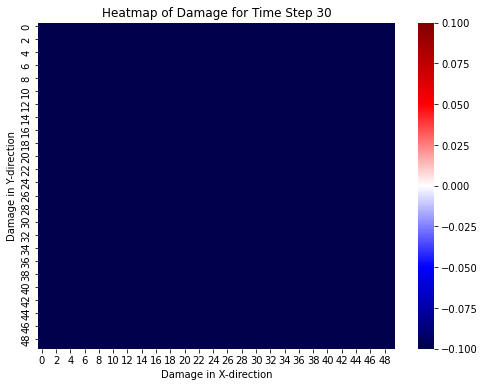

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter

# Assuming 'array' is your data with shape (30, 50, 50)
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Initialize the heatmap with the first timestep
heatmap = sns.heatmap(damage_param[0, :, :], cmap='seismic', ax=ax)
plt.title('Heatmap of Damage Over Time')
plt.xlabel('Damage in X-direction')
plt.ylabel('Damage in Y-direction')

# Function to update the heatmap for each frame in the animation
def update(frame):
    ax.clear()
    heatmap = sns.heatmap(damage_param[frame, :, :], cmap='seismic', ax=ax, cbar=False)
    ax.set_title(f'Heatmap of Damage for Time Step {frame + 1}')
    ax.set_xlabel('Damage in X-direction')
    ax.set_ylabel('Damage in Y-direction')

# Create the animation
anim = FuncAnimation(fig, update, frames=damage_param.shape[0], interval=200)

# Save the animation as a GIF
anim.save('damage_animation1.gif', writer=PillowWriter(fps=5))

# Alternatively, display the animation
plt.show() 
